In [ ]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import xgboost as xgb
import pickle

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv ('outbase.csv',sep=',',dtype= np.float64)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data=np.array(data)
print(data.shape)

(3719, 112)


In [ ]:
X = data[:, 1:111]
Y = data[:, 111]

In [ ]:
xtrain, xtest, trainY, testY = model_selection.train_test_split(X, Y, test_size = 0.3)

In [ ]:
#Scaling of data
SS = preprocessing.StandardScaler()
xtrain = SS.fit_transform(xtrain)
xtest = SS.transform (xtest)

In [ ]:
xtrain = xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1)
xtest = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)
print(xtrain.shape)
print(xtest.shape)

(2603, 110, 1)
(1116, 110, 1)


In [ ]:
# store min values
min_model = None 
min_losses = float('inf')

In [ ]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
def init():
    model = Sequential()
    model.add(Conv1D(32, 2, activation="relu", input_shape=(110, 1)))
    model.add(Flatten())
    model.add(Dense(200, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(150, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
        
    model.compile(loss="mse", optimizer="adam",metrics = ['mae', 'mse', r2_keras] )
    
    return model

In [ ]:
def train(models):
    global min_losses
    global min_model
    losses = []
    for i in range(len(models)):
        model = models[i]

        earlystop = keras.callbacks.EarlyStopping(
               monitor='mse',             # use mse for stopping
               min_delta=0.001, patience=5, 
               verbose=1, mode='auto')
        callbacks_list = [earlystop]


        history = model.fit(x=xtrain,y=trainY, epochs=1, validation_data=(xtest, testY),callbacks=callbacks_list)
        loss_val = round(history.history['loss'][-1], 3)
        losses.append(loss_val)

        if loss_val < min_losses:
            min_losses = loss_val
            min_model = model 


        # perform stuff on each model 
        
        
    return models, losses

In [ ]:
# Depending on the Application the number of generations may or maynot be fixed
no_of_generations = 20
no_of_individuals = 10
mutate_factor = 0.2
individuals = []

layers = [0, 3, 5]

In [ ]:
def mutate(new_individual):

    for i in layers:
        for bias in range(len(new_individual.layers[i].get_weights()[1])):
            n = random.random()
            if(n < mutate_factor):
                new_individual.layers[i].get_weights()[1][bias] *= random.uniform(-0.5, 0.5)

    for i in layers:
        for weight in new_individual.layers[i].get_weights()[0]:
            n = random.random()
            if(n < mutate_factor):
                for j in range(len(weight)):
                    if(random.random() < mutate_factor):
                        new_individual.layers[i].get_weights()[0][j] *= random.uniform(-0.5, 0.5)


    return new_individual

In [ ]:
def crossover(individuals):
    new_individuals = []

    new_individuals.append(individuals[0])
    new_individuals.append(individuals[1])

    for i in range(2, no_of_individuals):
        if(i < (no_of_individuals - 2)):
            if(i == 2):
                parentA = random.choice(individuals[:3])
                parentB = random.choice(individuals[:3])
            else:
                parentA = random.choice(individuals[:])
                parentB = random.choice(individuals[:])

            for i in layers:
                temp = parentA.layers[i].get_weights()[1]
                parentA.layers[i].get_weights()[1] = parentB.layers[i].get_weights()[1]
                parentB.layers[i].get_weights()[1] = temp

                new_individual = random.choice([parentA, parentB])
            
        else:
             new_individual = random.choice(individuals[:])

        new_individuals.append(mutate(new_individual))
        #new_individuals.append(new_individual)

    return new_individuals


In [ ]:
def evolve(individuals, losses):
    sorted_y_idx_list = sorted(range(len(losses)),key=lambda x:losses[x])
    individuals = [individuals[i] for i in sorted_y_idx_list ]

    #winners = individuals[:6]

    new_individuals = crossover(individuals)

    return new_individuals


In [ ]:
import timeit

In [ ]:
start = timeit.default_timer()
for i in range(no_of_individuals):
    individuals.append(init())

for generation in range(no_of_generations):
    individuals, losses = train(individuals)

    #best_for_gen = min(losses)
   # pos = losses.index(best_for_gen)
    #model = individuals[pos]

    

    # loop through one or pick one from each generation
    #model = individuals[0]
    #model.eva
    print(losses)

    individuals = evolve(individuals, losses)
stop = timeit.default_timer()

print('Time: ', stop - start)

82/82 [==============================] - 2s 13ms/step - loss: 1068.0566 - mae: 25.4297 - mse: 1068.0566 - r2_keras: -0.6545 - val_loss: 415.5537 - val_mae: 16.6483 - val_mse: 415.5537 - val_r2_keras: 0.3835
[701.328, 717.908, 716.986, 682.074, 714.807, 773.547, 672.733, 707.471, 707.667, 723.863]
82/82 [==============================] - 1s 11ms/step - loss: 292.8987 - mae: 13.3331 - mse: 292.8987 - r2_keras: 0.5756 - val_loss: 271.6147 - val_mae: 12.8831 - val_mse: 271.6147 - val_r2_keras: 0.5959
[346.691, 354.136, 289.215, 283.768, 350.399, 252.812, 362.146, 290.337, 361.548, 292.899]
82/82 [==============================] - 1s 12ms/step - loss: 233.9627 - mae: 11.4097 - mse: 233.9627 - r2_keras: 0.6563 - val_loss: 227.9515 - val_mae: 11.2723 - val_mse: 227.9515 - val_r2_keras: 0.6554
[247.385, 240.759, 229.616, 262.951, 248.349, 260.221, 229.193, 233.442, 210.362, 233.963]
82/82 [==============================] - 1s 12ms/step - loss: 213.5880 - mae: 10.5415 - mse: 213.5880 - r2_keras

In [ ]:
print(min_model)
print(min_losses)

135.162


In [ ]:
ypred = min_model.predict(xtest)

In [ ]:
test_loss = min_model.evaluate(xtest, testY)
print(test_loss)
print(np.sqrt(test_loss))

35/35 [==============================] - 0s 3ms/step - loss: 263.3455 - mae: 11.3212 - mse: 263.3455 - r2_keras: 0.6027
[263.345458984375, 11.321170806884766, 263.345458984375, 0.6027418375015259]
[16.2279222   3.36469476 16.2279222   0.7763645 ]


In [ ]:
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

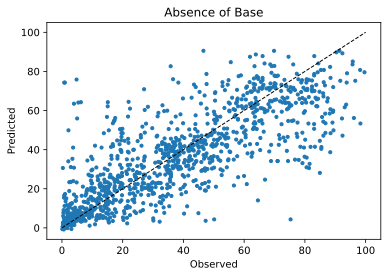

In [ ]:
fig, ax = plt.subplots()
ax.scatter(testY, ypred, s = 10)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=1, markersize=0.1)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title('Absence of Base')
#plt.savefig("Bagging.eps", format="eps")
#plt.show()
plt.savefig("No Base.jpg", format="jpg")
files.download('No Base.jpg')

